In [36]:
# !pip install agentpy pytransform3d IPython seaborn
# !conda install -y scipy joblib pandas

import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, cdist
import scipy.optimize as sio
import agentpy as ap
import matplotlib.pyplot as plt
import IPython
import random
import pytransform3d.plot_utils as p3d
from pytransform3d.transformations import translate_transform
import pandas as pd

plt.rc('animation', embed_limit=50)

%matplotlib widget

rng = np.random.default_rng(12345)
random.seed(12345)

In [2]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [98]:
class AircraftAgent(ap.Agent):
    def setup(self):
        self.max_vel = 205
        self.path = []

    def setup_fail(self, fail_prob):
        self.fail_prob = fail_prob
        self.failed = False

    def setup_pos(self, space: ap.Space):
        self.space = space
        self.neighbors = space.neighbors
        self.position = space.positions[self]

    def setup_goal(self, space: ap.Space, goal=np.array([0, 0, 0])):
        self.goal = goal
        self.path.append(goal)
        self.path_idx = 0

    def update(self):
        if random.random() < self.fail_prob and not self.failed:
            self.failed = True
            self.position[2] = 100
            for p in self.path:
                p[2] = 100
            self.space.move_to(self, self.position)
            return
        sub_goal = self.path[self.path_idx]
        vec_to_goal = sub_goal - self.position
        step_to_goal = normalize(vec_to_goal) * self.max_vel
        if (np.linalg.norm(step_to_goal) > np.linalg.norm(vec_to_goal)):
            try:
                self.space.remove_agents([self])
            except KeyError:
                pass
            return
        new_pos = self.position + step_to_goal
        self.position = new_pos
        self.space.move_to(self, new_pos)

In [133]:
class LimaModel(ap.Model):
    def setup(self):
        self.shape = np.array([self.p.xy_size, self.p.xy_size, self.p.z_size])
        self.space = ap.Space(self, shape=self.shape)
        self.agents = ap.AgentList(self, self.p.population, AircraftAgent)
        #         lanes = [self.get_random_lane() for agent in self.agents]
        start_pos = [rng.random(3) * self.shape for _ in self.agents]
        self.space.add_agents(self.agents, positions=start_pos)
        self.agents.setup_pos(self.space)
        self.agents.setup_fail(self.p.fail_prob)
        for agent, start in zip(self.agents, start_pos):
            goal = self.make_goal_pos(start)
            agent.setup_goal(self.space, goal)

        self.xy_sep_maxs = []
        self.z_sep_maxs = []
        self.xy_sep_means = []
        self.z_sep_means = []
        self.xy_sep_mins = []
        self.z_sep_mins = []
        self.tfc_dens = []
        self.conflict_counts = []
        self.pop = []

    def step(self):
        self.agents.update()
        if self.t % self.p.spawn_rate == 0:
            new_agent = AircraftAgent(self)
            self.agents.append(new_agent)
            self.space.add_agents([new_agent], [rng.random(3) * self.shape])
            new_agent.setup_pos(self.space)
            new_agent.setup_goal(self.space, rng.random(3) * self.shape)
            new_agent.setup_fail(self.p.fail_prob)

    def update(self):
        exp_positions = self.filter_exp_positions(self.agents.position)
        n_agents = len(exp_positions)

        if len(self.space.agents) < 1:
            self.end()
            return

        # Separations
        xy_seps = pdist(exp_positions[:, :2], 'euclidean')
        z_seps = pdist(np.vstack((exp_positions[:, 2], np.zeros(exp_positions.shape[0]))).T, 'euclidean')
        # assert xy_seps.shape[0] == z_seps.shape[0]
        # xy_seps = xy_seps[xy_seps > 0.0]  # Remove distance from self
        # z_seps = z_seps[z_seps > 0.0]  # Remove distance from self
        # assert xy_seps.shape[0] == z_seps.shape[0]
        self.record('Mean XY Sep', xy_seps.mean())
        self.record('Mean Z Sep', z_seps.mean())
        self.record('Min XY Sep', xy_seps.min())
        self.record('Min Z Sep', z_seps.min())
        self.record('Max XY Sep', xy_seps.max())
        self.record('Max Z Sep', z_seps.max())
        xy_conflicts = xy_seps < self.p.conflict_xy_dist
        z_conflicts = z_seps < self.p.conflict_z_dist
        conflicts = np.logical_and(xy_conflicts, z_conflicts)
        self.record('Instant Conflict Counts', conflicts.sum())
        self.record('Instant Population', n_agents)

        self.xy_sep_maxs += [xy_seps.max()]
        self.z_sep_maxs += [z_seps.max()]
        self.xy_sep_mins += [xy_seps.min()]
        self.z_sep_mins += [z_seps.min()]
        self.xy_sep_means += [xy_seps.mean()]
        self.z_sep_means += [z_seps.mean()]
        self.tfc_dens += [n_agents / (self.p.xy_size * self.p.xy_size * self.p.z_size)]
        self.pop += [n_agents]

        # Traffic Densities
        self.record('Traffic Density', n_agents / (self.p.xy_size * self.p.xy_size * self.p.z_size))

    def end(self):
        self.report('Min XY Sep', np.array(self.xy_sep_mins).min())
        self.report('Min Z Sep', np.array(self.z_sep_mins).min())
        self.report('Mean XY Sep', np.array(self.xy_sep_means).mean())
        self.report('Mean Z Sep', np.array(self.z_sep_means).mean())
        self.report('Max XY Sep', np.array(self.xy_sep_maxs).max())
        self.report('Max Z Sep', np.array(self.z_sep_maxs).max())
        self.report('Max Traffic Density', np.array(self.tfc_dens).max())
        self.report('Min Traffic Density', np.array(self.tfc_dens).min())
        self.report('Mean Traffic Density', np.array(self.tfc_dens).mean())
        self.report('Mean Instant Conflict Count', np.array(self.conflict_counts).mean())
        self.report('Mean Population', np.array(self.pop).mean())

    def get_random_lane(self):
        return random.choice(self.p.lanes)

    def make_goal_pos(self, start):
        xy_goal = np.array(rng.random(2)*self.p.xy_size)
        dist = np.linalg.norm(xy_goal-start[:2])
        climb_or_descend = rng.random() > 0.5
        vert_dist = dist*np.sin(np.radians(self.p.vert_angle))
        z_goal = start[2]+vert_dist if climb_or_descend else start[2]-vert_dist
        return np.hstack([xy_goal, z_goal])

    def filter_exp_positions(self, positions):
        positions = np.array(positions)
        midpoint = np.array([self.p.xy_size // 2, self.p.xy_size // 2, self.p.z_size // 2])
        xy_distances = np.array([np.linalg.norm(pos[:2]-midpoint[:2]) for pos in positions])
        return positions[xy_distances < self.p.xy_size*0.8]


In [134]:
params = {
    'xy_size': 648200, #350nm
    'z_size': 3048, #10000ft
    'population': 200,
    'steps': 20000,
    'vert_angle': 5.6,
    'conflict_xy_dist': 9260, #5nm
    'conflict_z_dist': 305, #1000ft
    'spawn_rate': 10000,  #steps per spawn
    'fail_prob': 0.0,  # Failure probability of each agent at each timestep
}
model = LimaModel(params)
results = model.run()

Completed: 20000 steps
Run time: 0:02:36.292684
Simulation finished


C:\Users\Aliak\AppData\Local\Temp\ipykernel_23772\1500923786.py:84: RuntimeWarning: Mean of empty slice.
  self.report('Mean Instant Conflict Count', np.array(self.conflict_counts).mean())
C:\ANACON~1\envs\sandbox\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [135]:
df = results.variables.LimaModel

In [136]:
df

,Mean XY Sep,Mean Z Sep,Min XY Sep,Min Z Sep,Max XY Sep,Max Z Sep,Instant Conflict Counts,Instant Population,Traffic Density
t,,,,,,,,,
0,329883.840816,989.987615,1488.783515,0.032662,880327.636347,3029.908472,2,200,1.561698e-13
1,329723.391144,991.475466,1255.624546,0.032662,880003.332751,3015.193975,2,200,1.561698e-13
2,329563.078607,993.407738,1056.319082,0.032662,879679.052754,3043.641841,2,200,1.561698e-13
3,329402.905595,995.577125,913.305731,0.032662,879354.796382,3048.000000,2,200,1.561698e-13
4,329242.875015,998.107920,855.304080,0.000000,879030.563662,3048.000000,2,200,1.561698e-13
...,...,...,...,...,...,...,...,...,...
19996,343268.962675,1522.147867,1999.190845,0.000000,826436.679939,3048.000000,5,201,1.569506e-13
19997,343268.962675,1522.147867,1999.190845,0.000000,826436.679939,3048.000000,5,201,1.569506e-13
19998,343268.962675,1522.147867,1999.190845,0.000000,826436.679939,3048.000000,5,201,1.569506e-13


<AxesSubplot:xlabel='Instant Population', ylabel='Instant Conflict Counts'>

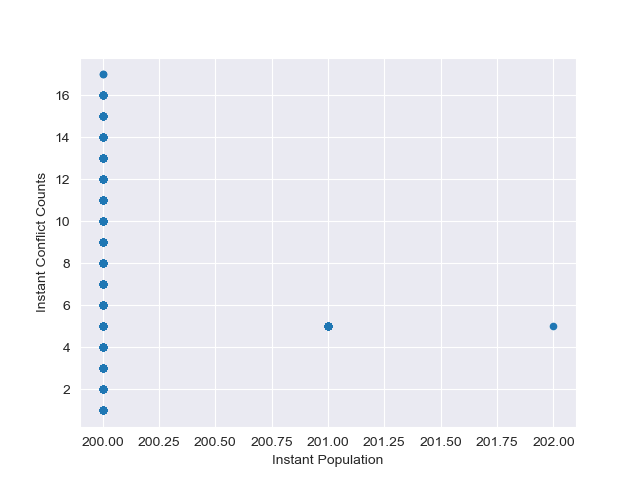

In [137]:
df.plot('Instant Population', 'Instant Conflict Counts', kind='scatter')

<AxesSubplot:xlabel='Traffic Density', ylabel='Mean 3D Sep'>

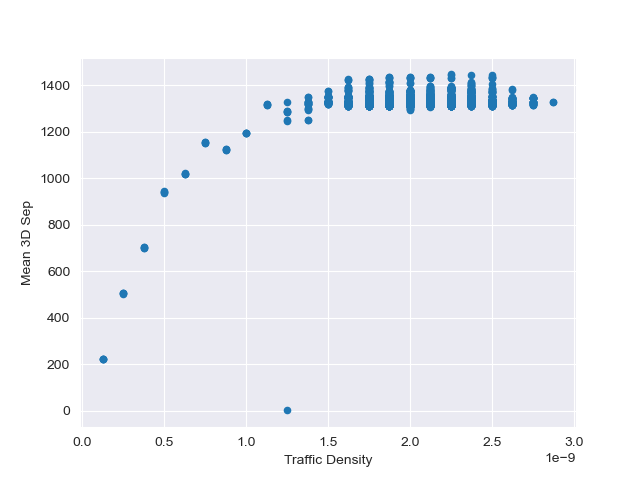

In [18]:
df.plot(x='Traffic Density', y='Mean 3D Sep', kind='scatter')

In [19]:
param_ranges = {
    'seed': 12345,
    'ndim': 3,
    'size': 5000,
    'population': ap.IntRange(2, 5000),
    'steps': 1000,
    'n_layers': 10,
    'spawn_rate': 2000,  #steps per spawn
    'fail_prob': 0.0,  # Failure probability of each agent at each timestep
}
sample = ap.Sample(param_ranges, n=32, method='saltelli')
exp = ap.Experiment(LimaModel, sample, record=True)
exp_results = exp.run(n_jobs=-1)

Scheduled runs: 128
Experiment finished
Run time: 0:09:14.302262


In [20]:
res = exp_results.arrange_reporters()
res

,sample_id,seed,Min 3D Sep,Mean 3D Sep,Max 3D Sep,Max Traffic Density,Min Traffic Density,Mean Traffic Density,Mean Population,population
0,0,326292558536748812723901523992421184800,0.058096,1.327689,3.168286,2.950000e-08,2.950000e-08,2.950000e-08,236.0,236
1,1,285839514907087782789443464132181774243,0.018798,1.340559,3.228585,1.661250e-07,1.661250e-07,1.661250e-07,1329.0,1329
2,2,241668451003847905131209953533158325304,0.058096,1.327689,3.168286,2.950000e-08,2.950000e-08,2.950000e-08,236.0,236
3,3,61348850456896918006170475963069914957,0.018798,1.340559,3.228585,1.661250e-07,1.661250e-07,1.661250e-07,1329.0,1329
4,4,266636625861545222455453704590856411026,0.006424,1.338721,3.228585,3.418750e-07,3.418750e-07,3.418750e-07,2735.0,2735
...,...,...,...,...,...,...,...,...,...,...
123,123,67131655591496897482863825789551849415,0.018798,1.341891,3.228585,1.857500e-07,1.857500e-07,1.857500e-07,1486.0,1486
124,124,103199347541669926777453505314749220842,0.058337,1.375797,3.010812,1.000000e-08,1.000000e-08,1.000000e-08,80.0,80
125,125,296480509178182919968051883547818156134,0.003050,1.333110,3.294314,4.981250e-07,4.981250e-07,4.981250e-07,3985.0,3985
126,126,299645333029616535149493790526090241495,0.058337,1.375797,3.010812,1.000000e-08,1.000000e-08,1.000000e-08,80.0,80


<AxesSubplot:xlabel='Mean Traffic Density', ylabel='Min 3D Sep'>

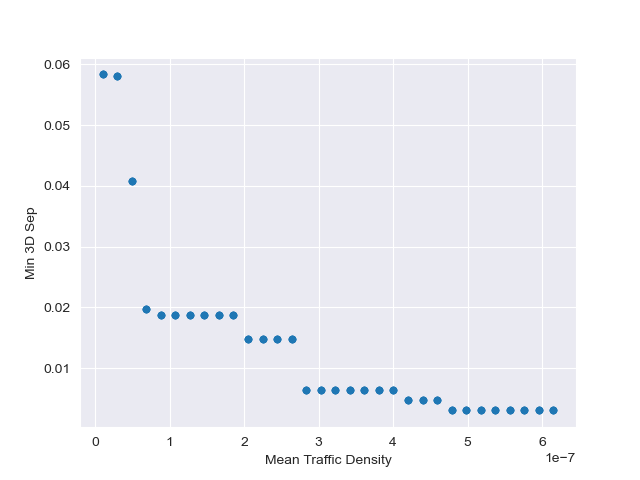

In [21]:
exp_df = exp_results.reporters
exp_df.plot('Mean Traffic Density', 'Min 3D Sep', kind='scatter')

In [22]:
exp_results.calc_sobol().sensitivity.sobol

,order,S1,ST,S2
,parameter,,,population
reporter,parameter,,,
Min 3D Sep,population,0.971003,0.971003,NaN
Mean 3D Sep,population,1.197159,1.197159,NaN
Max 3D Sep,population,1.252171,1.252171,NaN
Max Traffic Density,population,0.991049,0.991049,NaN
Min Traffic Density,population,0.991049,0.991049,NaN
Mean Traffic Density,population,0.991049,0.991049,NaN
Mean Population,population,0.991049,0.991049,NaN


In [23]:
plt.rcParams["axes.labelsize"] = 18
plt.tight_layout()
sns.heatmap(exp_results.reporters.corr(), annot=True)

<AxesSubplot:>

<AxesSubplot:xlabel='Max Traffic Density', ylabel='Min 3D Sep'>

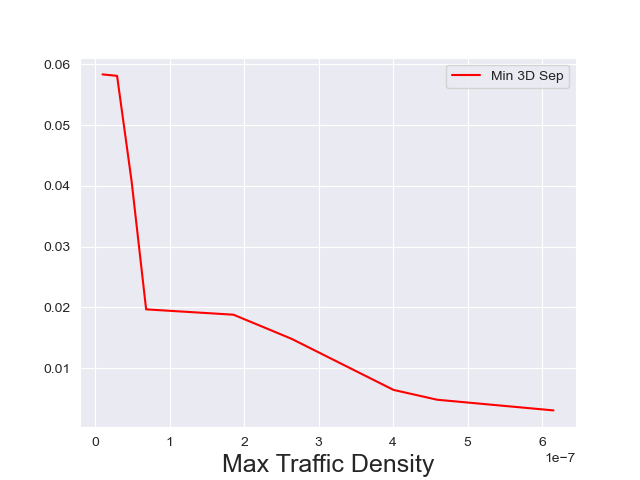

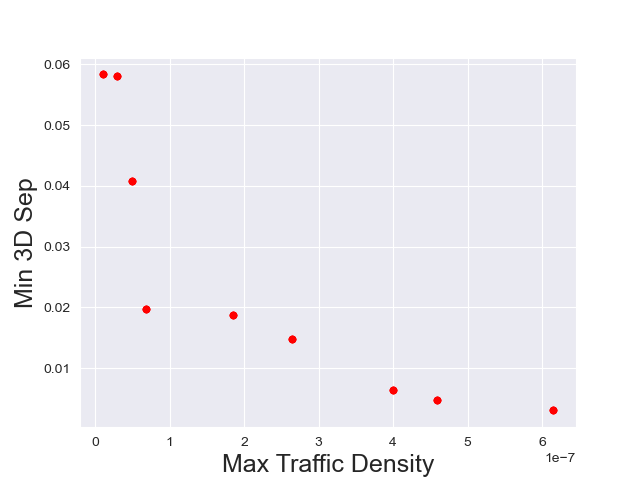

In [24]:
def count_diffs(a, b, to_min, to_max):
    n_better = 0
    n_worse = 0

    for f in to_min:
        n_better += a[f] < b[f]
        n_worse += a[f] > b[f]

    for f in to_max:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse


def find_skyline_bnl(df, to_min, to_max):
    """Finds the skyline using a block-nested loop."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_min, to_max)

            # Case 1
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 3
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        skyline = skyline.difference(to_drop)
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)


pareto_front = find_skyline_bnl(exp_df, to_min=[], to_max=['Mean Traffic Density', 'Min 3D Sep'])
# exp_df[pareto_front].sort_values('Mean Traffic Density').plot('Mean Traffic Density')
exp_df[pareto_front].sort_values('Mean Traffic Density').plot('Max Traffic Density', 'Min 3D Sep', c='r')
exp_df[pareto_front].sort_values('Mean Traffic Density').plot('Max Traffic Density', 'Min 3D Sep', kind='scatter',
                                                              c='r')

In [25]:
print(exp_df['Traffic Density'][exp_df['Traffic Density'] < exp_df['Traffic Density'].quantile(0.9)])
print(exp_df['Traffic Density'])

KeyError: 'Traffic Density'

<AxesSubplot:xlabel='Max Traffic Density', ylabel='Min 3D Sep'>

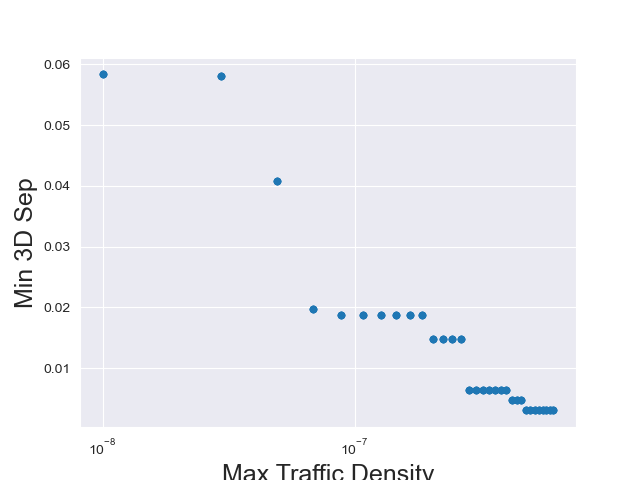

In [26]:
exp_df.plot(x='Max Traffic Density', y='Min 3D Sep', kind='scatter', logx=True)

In [5]:
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    pos = m.space.agents.position
    pos = np.array(list(pos)).T  # Transform
    ax.scatter(*pos, s=1, c='black')
    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)


#     for lane in m.p.lanes:
#         ax.scatter(*lane[0], c='r')
#         ax.scatter(*lane[1], c='b')
#         half_height_start = lane[0][2]/2
#         start_atz_centre = np.array([lane[0][0], lane[0][1], half_height_start])
#         half_height_end = lane[1][2]/2
#         end_atz_centre = np.array([lane[1][0], lane[1][1], half_height_end])
#         p3d.plot_cylinder(ax=ax, wireframe=False, alpha=0.2, radius=20, length=lane[0][2], A2B=translate_transform(np.eye(4), start_atz_centre))
#         p3d.plot_cylinder(ax=ax, wireframe=False, alpha=0.2, radius=20, length=lane[1][2], A2B=translate_transform(np.eye(4), end_atz_centre))

#     ax.set_axis_off()

def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))

In [15]:
params = {
    'xy_size': 2000,
    'z_size': 2000,
    'population': 10,
    'steps': 500,
    'spawn_rate': 5,  #steps per spawn
    'fail_prob': 0.0,  # Failure probability of each agent at each timestep
    #     'lanes': [[[20,50,200], [1800,50,200]], [[1800,1500,200], [20,1500,200]]]
}
animation_plot(LimaModel, params)

TypeError: Axes3D.scatter() missing 2 required positional arguments: 'xs' and 'ys'